Package installation 

pip install canari

In [2]:
import sys
import os
from pathlib import Path
# project_root = Path.cwd().parent
# sys.path.append(project_root)
project_root = Path("/Users/vuongdai/GitHub/canari")  
sys.path.append(str(project_root))  
data_file = os.path.join(project_root, "data", "toy_time_series","sine.csv")
data_file_time = os.path.join(project_root, "data", "toy_time_series","sine_datetime.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    Periodic,
    Autoregression,
    WhiteNoise,
    Model,
    plot_data,
    plot_prediction,
)
from examples import DataProcess
import pytagi.metric as metric
from pytagi import Normalizer as normalizer
import copy

Read data using pandas 

In [3]:
df_raw = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
linear_space = np.linspace(0, 2, num=len(df_raw))
df_raw = df_raw.add(linear_space, axis=0)

time_series = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_series = pd.to_datetime(time_series[0])
df_raw.index = time_series
df_raw.index.name = "date_time"
df_raw.columns = ["values"]

In [4]:
# Resampling data
df = df_raw.resample("H").mean()

Data pre-processing:
1. Our provided tool
2. Scikit learn

In [5]:
# Define parameters
output_col = [0]
num_epoch = 50

data_processor = DataProcess(
    data=df,
    train_split=0.8,
    validation_split=0.2,
    output_col=output_col,
)

train_data, validation_data, test_data, normalized_data = data_processor.get_splits()


Plot data

In [10]:
# Model
model = Model(
    LocalTrend(),
    LstmNetwork(
        look_back_len=19,
        num_features=1,
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    ),
    WhiteNoise(std_error=0.003),
)
model.auto_initialize_baseline_states(train_data["y"][0:24])

Define model's components

In [11]:
# Training
for epoch in range(num_epoch):
    (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    # Unstandardize the predictions
    mu_validation_preds = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[output_col],
        data_processor.norm_const_std[output_col],
    )
    std_validation_preds = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[output_col],
    )

    # Calculate the log-likelihood metric
    validation_obs = data_processor.get_data("validation").flatten()
    mse = metric.mse(mu_validation_preds, validation_obs)

    # Early-stopping
    model.early_stopping(evaluate_metric=mse, mode="min")
    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds
        std_validation_preds_optim = std_validation_preds
        states_optim = copy.copy(
            states
        )  # If we want to plot the states, plot those from optimal epoch
    if model.stop_training:
        break

Define model

In [12]:
print(f"Optimal epoch       : {model.optimal_epoch}")
print(f"Validation MSE      :{model.early_stop_metric: 0.4f}")

Optimal epoch       : 49
Validation MSE      : 0.0000


Plot predictions

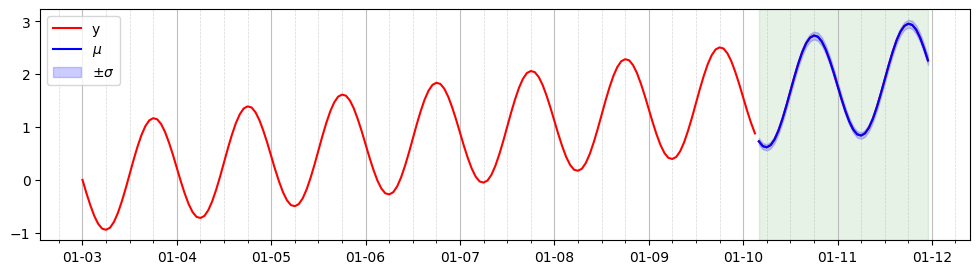

In [18]:
#  Plot
fig, ax = plt.subplots(figsize=(12, 3))
plot_data(
    data_processor=data_processor,
    normalization=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred=std_validation_preds,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()